# Prompt Explorer

This is a notebook for exploring prompts and seeds. Random seeds are generated and displayed. The idea is to have this running alongside other more complicated notebooks, but this one doesn't needs to have gdrive connection. Then when finding cool prompt/seed combos, but them in the prompts google sheet and have those more complex notebooks reference the sheet vs defining prompts as variables in the code.

In [3]:
import os
import pandas as pd
import numpy as np
from google.colab import drive
from IPython.display import clear_output

drive.mount('/content/gdrive')

song_name = 'spacetrain_1024' #@param {type:"string"}
res_height = 576 #@param
res_width = 1024 #@param

code_folder = '/content/gdrive/MyDrive/AI-Art Lee'

# fp = os.path.join(code_folder, 'input_data.xlsx')
# df_prompt = pd.read_excel(fp, 'prompts_{}'.format(song_name), index_col=0).dropna(how='all')
# df_prompt

fp = os.path.join(code_folder, song_name, 'prompt_image_definitions.csv')
df_prompt = pd.read_csv(fp, index_col=0).dropna(how='all')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
%%capture
!pip install diffusers
!pip install transformers scipy ftfy accelerate

import torch
from diffusers import StableDiffusionPipeline

In [5]:

pipe = StableDiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-2-1",
                                               torch_dtype=torch.float16,
                                               safety_checker=None
                                               )


pipe = pipe.to("cuda")

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Prompt: a floating tram, descending into an alien world, Matte Painting, retrowave color scheme, purple orange yellow maroon, full view of vehicle
Seeds: [2695595417331472, 4519426326315673, 2691168416487283, 6387575286048161]


  0%|          | 0/50 [00:00<?, ?it/s]

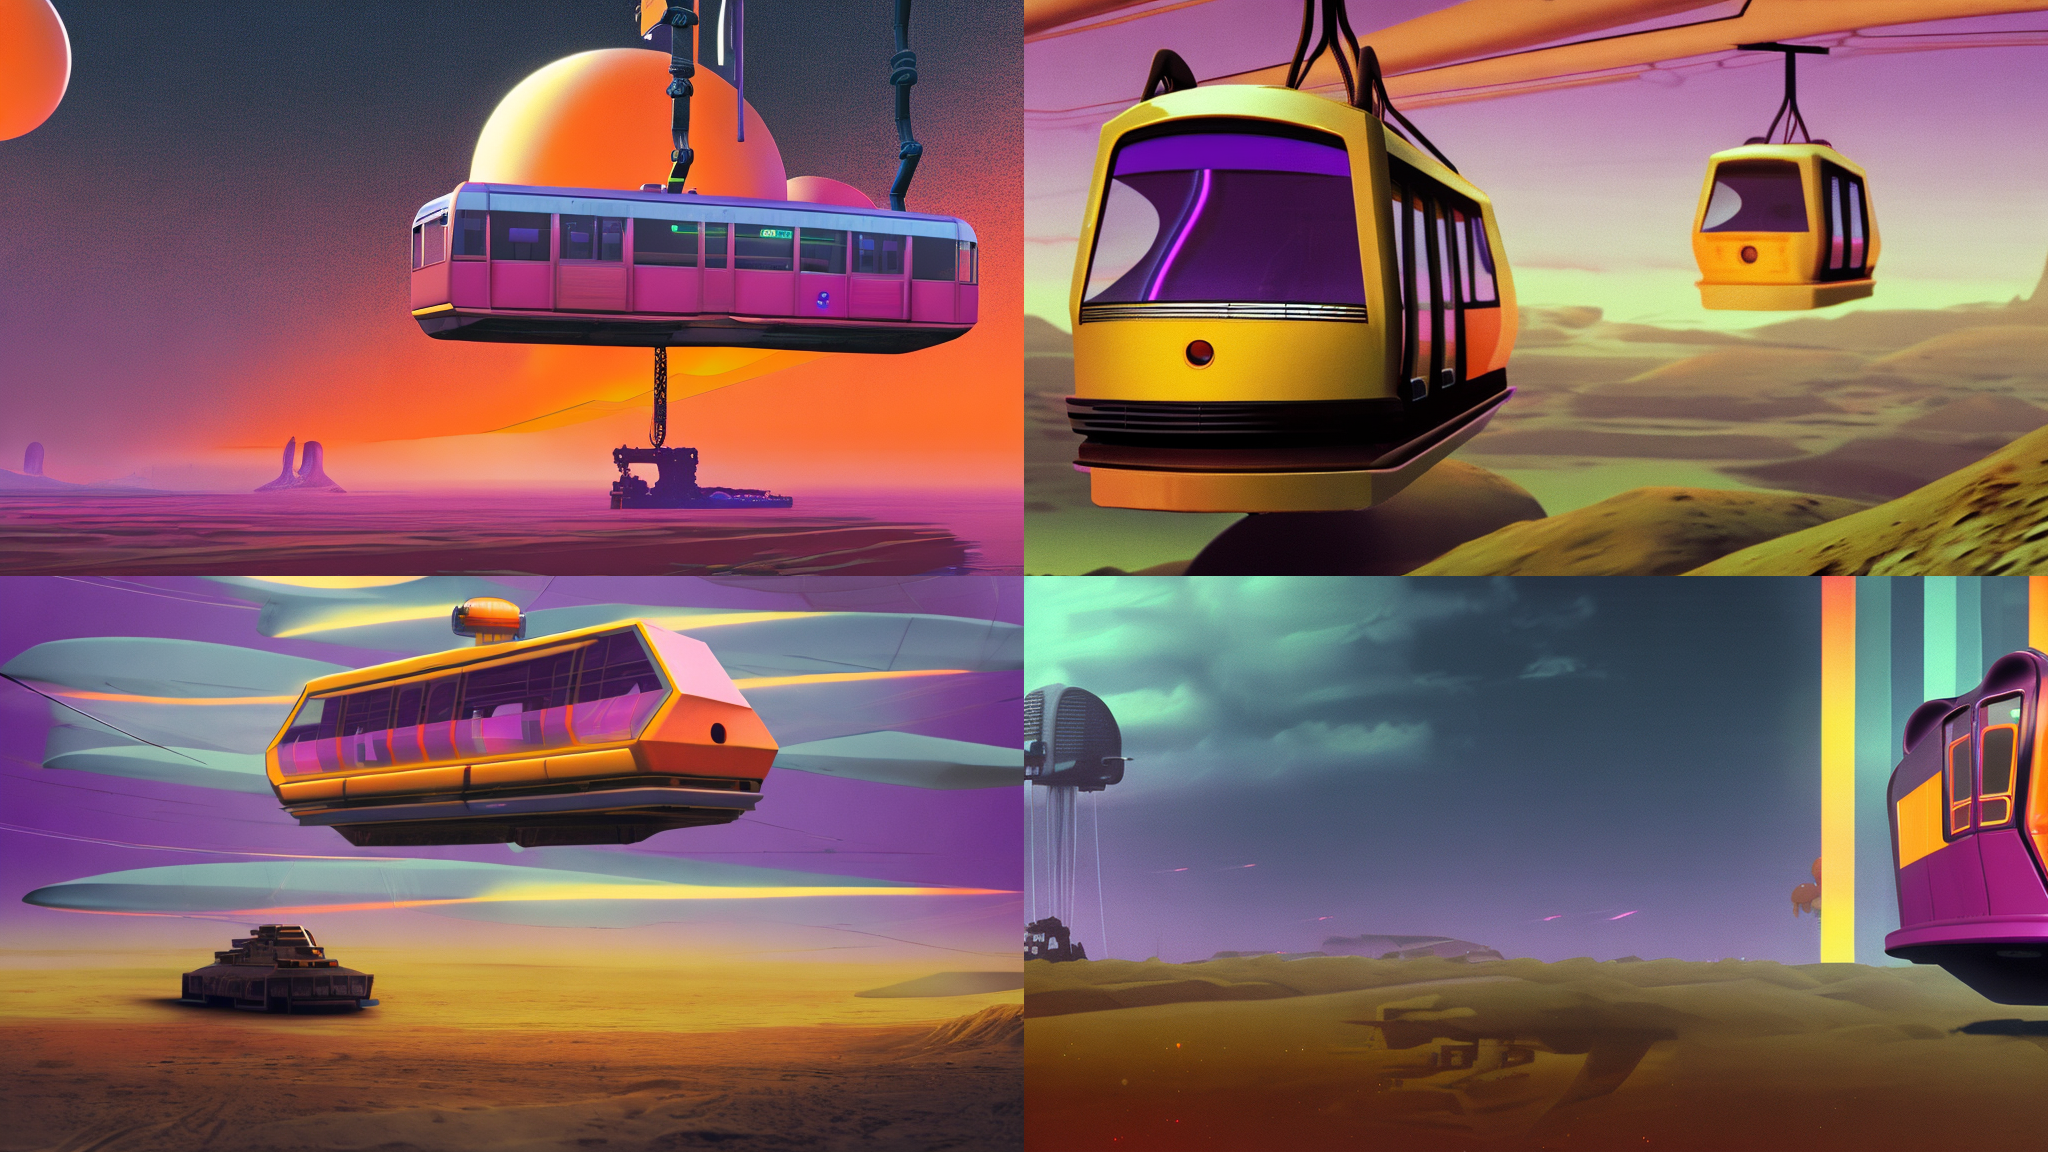

In [7]:
from PIL import Image

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid


# # https://huggingface.co/docs/diffusers/using-diffusers/reusing_seeds

# prompt_name = 'spring forest2'
# prompt = df_prompt['prompt'][prompt_name]
# guidance_scale = float(df_prompt['guidance_scale'][prompt_name])


prompt_components = [
    "a floating tram",
    "descending into an alien world",
    "Matte Painting",
    "retrowave color scheme",
    "purple orange yellow maroon",
    "full view of vehicle",
]

prompt = ", ".join(prompt_components)

# rows X cols of images. Reduce for speed and memory issues.
rows = 2
cols = 2

num_images = rows*cols

# Make new random seeds in a hacky way. TODO: probably a function to generate seeds without making a generator instance.

generator = torch.Generator(device="cuda")
seeds = [generator.seed() for i in range(num_images)]
generator = [torch.Generator(device="cuda").manual_seed(seed) for seed in seeds]

print("Prompt: {}".format(prompt))
print("Seeds: {}".format(seeds))

images = pipe(prompt, generator=generator, num_images_per_prompt=rows*cols, width=res_width, height=res_height).images

image_grid(images, rows=rows, cols=cols)